<h2 align=center> Fine-Tune BERT for Text Classification with TensorFlow</h2>

<div align="center">
    <img width="512px" src='https://drive.google.com/uc?id=1fnJTeJs5HUpz7nix-F9E6EZdgUflqyEu' />
    <p style="text-align: center;color:gray">Figure 1: BERT Classification Model</p>
</div>

In this Notebook, we will fine-tune a BERT model for text classification using TensorFlow and TF-Hub.

The pretrained BERT model used in this project is [available](https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2) on [TensorFlow Hub](https://tfhub.dev/).

### Objectives

In this project, we will:

- Build TensorFlow Input Pipelines for Text Data with the [`tf.data`](https://www.tensorflow.org/api_docs/python/tf/data) API
- Tokenize and Preprocess Text for BERT
- Fine-tune BERT for text classification with TensorFlow 2 and [TF Hub](https://tfhub.dev)

### Contents

This project/notebook consists of several Tasks.

 1. Download and Import the Quora Insincere Questions Dataset
 2. Create tf.data.Datasets for Training and Evaluation
 3. Download a Pre-trained BERT Model from TensorFlow Hub
 4. Tokenize and Preprocess Text for BERT
 5. Wrap a Python Function into a TensorFlow op for Eager Execution
 6. Create a TensorFlow Input Pipeline with `tf.data`
 7. Add a Classification Head to the BERT `hub.KerasLayer`
 8. Fine-Tune BERT for Text Classification
 9. Evaluate the BERT Text Classification Model

In [1]:
# !nvidia-smi  # To chech the GPU we are currently using.

### Install TensorFlow and TensorFlow Model Garden

In [1]:
import tensorflow as tf
print(tf.version.VERSION)

2.3.0


In [ ]:
#!pip install -q tensorflow==2.3.0

In [2]:
!git clone --depth 1 -b v2.3.0 https://github.com/tensorflow/models.git

fatal: destination path 'models' already exists and is not an empty directory.


In [3]:
# install requirements to use tensorflow/models repository
!pip install -Uqr models/official/requirements.txt
# you may have to restart the runtime afterwards

## Download and Import the Quora Insincere Questions Dataset

In [4]:
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import sys
sys.path.append('models')
from official.nlp.data import classifier_data_lib
from official.nlp.bert import tokenization
from official.nlp import optimization

/usr/local/lib/python3.7/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:67: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.5.0 and strictly below 2.8.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.3.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


In [5]:
print("TF Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

TF Version:  2.3.0
Eager mode:  True
Hub version:  0.12.0
GPU is available


A downloadable copy of the [Quora Insincere Questions Classification data](https://www.kaggle.com/c/quora-insincere-questions-classification/data) can be found [https://archive.org/download/fine-tune-bert-tensorflow-train.csv/train.csv.zip](https://archive.org/download/fine-tune-bert-tensorflow-train.csv/train.csv.zip). Decompress and read the data into a pandas DataFrame.

In [6]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
df = pd.read_csv('https://archive.org/download/fine-tune-bert-tensorflow-train.csv/train.csv.zip',compression='zip',low_memory=False)
df.shape


(1306122, 3)

In [7]:
df.tail(10)

,qid,question_text,target
1306112,ffffa5b0fa76431c063f,Are you ashamed of being an Indian?,1
1306113,ffffae5dbda3dc9e9771,What are the methods to determine fossil ages ...,0
1306114,ffffba7c4888798571c1,What is your story today?,0
1306115,ffffc0c7158658a06fd9,How do I consume 150 gms protein daily both ve...,0
1306116,ffffc404da586ac5a08f,What are the good career options for a msc che...,0
1306117,ffffcc4e2331aaf1e41e,What other technical skills do you need as a c...,0
1306118,ffffd431801e5a2f4861,Does MS in ECE have good job prospects in USA ...,0
1306119,ffffd48fb36b63db010c,Is foam insulation toxic?,0
1306120,ffffec519fa37cf60c78,How can one start a research project based on ...,0
1306121,ffffed09fedb5088744a,Who wins in a battle between a Wolverine and a...,0


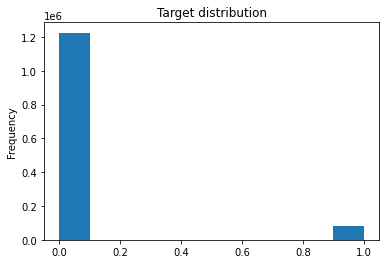

In [8]:
df.target.plot(kind='hist',title='Target distribution');

## Create tf.data.Datasets for Training and Evaluation

In [9]:
train_df, remaining = train_test_split(df, random_state=42, train_size=0.0075, stratify=df.target.values)
valid_df, _ = train_test_split(remaining, random_state=42, train_size=0.00075, stratify=remaining.target.values)
train_df.shape, valid_df.shape

((9795, 3), (972, 3))

In [10]:
with tf.device('/cpu:0'):
  train_data = tf.data.Dataset.from_tensor_slices((train_df['question_text'].values, train_df['target'].values))
  valid_data = tf.data.Dataset.from_tensor_slices((valid_df.question_text.values, valid_df.target.values))

  for text, label in train_data.take(1):
    print(text)
    print(label)



tf.Tensor(b'Why are unhealthy relationships so desirable?', shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int64)


## Download a Pre-trained BERT Model from TensorFlow Hub

In [11]:
"""
Each line of the dataset is composed of the review text and its label
- Data preprocessing consists of transforming text to BERT input features:
input_word_ids, input_mask, segment_ids
- In the process, tokenizing the text is done with the provided BERT model tokenizer
"""

label_list = [0, 1]  # Label categories
max_seq_length = 128 # maximum length of (token) input sequences
train_batch_size = 32 

# Get BERT layer and tokenizer:
# More details here: https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2", trainable=True)

vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)


In [12]:
tokenizer.wordpiece_tokenizer.tokenize('hi, how are you doing?')

['hi', '##,', 'how', 'are', 'you', 'doing', '##?']

In [13]:
tokenizer.convert_tokens_to_ids(tokenizer.wordpiece_tokenizer.tokenize('hi, how are you doing?'))

[7632, 29623, 2129, 2024, 2017, 2725, 29632]

## Tokenize and Preprocess Text for BERT

<div align="center">
    <img width="512px" src='https://drive.google.com/uc?id=1-SpKFELnEvBMBqO7h3iypo8q9uUUo96P' />
    <p style="text-align: center;color:gray">Figure 2: BERT Tokenizer</p>
</div>

Transforming our data into a format BERT understands.
1. We create InputExamples using `classifier_data_lib`'s constructor `InputExample` provided in the BERT library.

In [14]:
# This provides a function to convert row to input features and label

def to_feature(text, label, label_list=label_list, max_seq_length=max_seq_length, tokenizer=tokenizer):
  example = classifier_data_lib.InputExample(guid=None,
                                             text_a = text.numpy(),
                                             text_b = None,
                                             label = label.numpy())
  
  feature = classifier_data_lib.convert_single_example(0, example, label_list, max_seq_length, tokenizer)

  return (feature.input_ids, feature.input_mask, feature.segment_ids, feature.label_id)
  
  

You want to use [`Dataset.map`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map) to apply this function to each element of the dataset. [`Dataset.map`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map) runs in graph mode.

- Graph tensors do not have a value.
- In graph mode you can only use TensorFlow Ops and functions.

So you can't `.map` this function directly: You need to wrap it in a [`tf.py_function`](https://www.tensorflow.org/api_docs/python/tf/py_function). The [`tf.py_function`](https://www.tensorflow.org/api_docs/python/tf/py_function) will pass regular tensors (with a value and a `.numpy()` method to access it), to the wrapped python function.

## Wrap a Python Function into a TensorFlow op for Eager Execution

In [15]:
def to_feature_map(text, label):
  input_ids, input_mask, segment_ids, label_id = tf.py_function(to_feature, inp=[text, label],
                                                                Tout=[tf.int32, tf.int32, tf.int32, tf.int32])
  input_ids.set_shape([max_seq_length])
  input_mask.set_shape([max_seq_length])
  segment_ids.set_shape([max_seq_length])
  label_id.set_shape([])

  x =  {
      'input_word_ids': input_ids,
      'input_mask': input_mask,
      'input_type_ids':segment_ids
  }
  
  return (x, label_id)
  

## Creating a TensorFlow Input Pipeline with `tf.data`

In [16]:
with tf.device('/cpu:0'):
  # train
  train_data = (train_data.map(to_feature_map,
                               num_parallel_calls=tf.data.experimental.AUTOTUNE)
  .shuffle(1000)
  .batch(32, drop_remainder=True)
  .prefetch(tf.data.experimental.AUTOTUNE))

  # valid
  valid_data = (valid_data.map(to_feature_map,
                               num_parallel_calls=tf.data.experimental.AUTOTUNE)
  .batch(32, drop_remainder=True)
  .prefetch(tf.data.experimental.AUTOTUNE))
  

The resulting `tf.data.Datasets` return `(features, labels)` pairs, as expected by [`keras.Model.fit`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit):

In [17]:
# train data spec
train_data.element_spec

({'input_mask': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_word_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int32, name=None))

In [18]:
# valid data spec
valid_data.element_spec

({'input_mask': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_word_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int32, name=None))

## Add a Classification Head to the BERT Layer

<div align="center">
    <img width="512px" src='https://drive.google.com/uc?id=1fnJTeJs5HUpz7nix-F9E6EZdgUflqyEu' />
    <p style="text-align: center;color:gray">Figure 3: BERT Layer</p>
</div>

In [19]:
# Building the model
def create_model():
  input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                         name='input_word_ids')
  input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                         name='input_mask')
  input_type_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                         name='input_type_ids')
  
  pooled_output, sequence_output =bert_layer([input_word_ids, input_mask, input_type_ids])
  
  drop = tf.keras.layers.Dropout(0.4)(pooled_output)
  output = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(drop)

  model = tf.keras.Model(
      inputs={
          'input_word_ids':input_word_ids,
          'input_mask': input_mask,
          'input_type_ids': input_type_ids
      },
      outputs=output)
  return model

## Fine-Tune BERT for Text Classification

In [20]:
model = create_model()
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_type_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]      

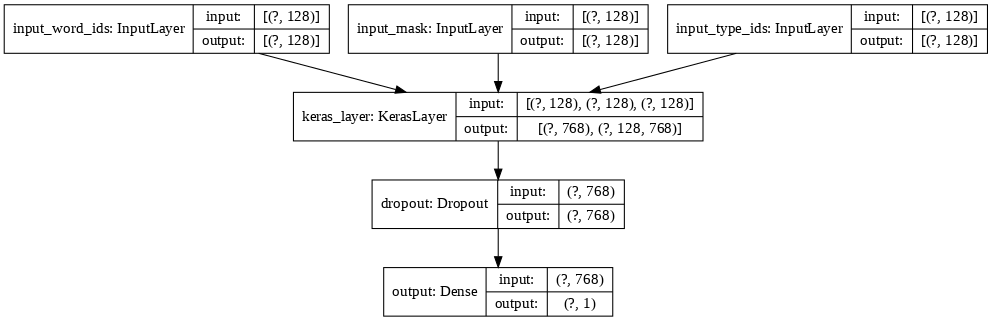

In [21]:
tf.keras.utils.plot_model(model=model, show_shapes=True, dpi=76)

In [22]:
# Train model
epochs = 4
history = model.fit(train_data,
                    validation_data=valid_data,
                    epochs=epochs,
                    verbose=1)

Epoch 1/4
306/306 [==============================] - ETA: 0s - loss: 0.1871 - binary_accuracy: 0.9313WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0256s vs `on_test_batch_end` time: 0.5165s). Check your callbacks.


306/306 [==============================] - 485s 2s/step - loss: 0.1871 - binary_accuracy: 0.9313 - val_loss: 0.1350 - val_binary_accuracy: 0.9552
Epoch 2/4
306/306 [==============================] - 484s 2s/step - loss: 0.1083 - binary_accuracy: 0.9584 - val_loss: 0.1339 - val_binary_accuracy: 0.9510
Epoch 3/4
306/306 [==============================] - 484s 2s/step - loss: 0.0587 - binary_accuracy: 0.9808 - val_loss: 0.1585 - val_binary_accuracy: 0.9552
Epoch 4/4
306/306 [==============================] - 484s 2s/step - loss: 0.0331 - binary_accuracy: 0.9894 - val_loss: 0.1910 - val_binary_accuracy: 0.9604


## Evaluate the BERT Text Classification Model

In [23]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

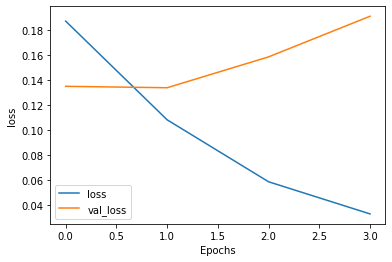

In [24]:
plot_graphs(history, 'loss')

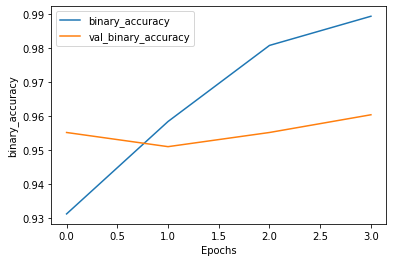

In [25]:
plot_graphs(history, 'binary_accuracy')

In [34]:
sample_example = ["Who the hell are you", " what's ur mail Id", "are you mad","Where can i find it", "shut the fuck up", " The hell's wrong with you", "you twisted psycho"]
test_data = tf.data.Dataset.from_tensor_slices((sample_example, [0]*len(sample_example)))
test_data = (test_data.map(to_feature_map).batch(1))
preds = model.predict(test_data)
threshold = 0.7   #between 0 and 1

['Insincere' if pred >= threshold else 'Sincere' for pred in preds]

['Sincere',
 'Sincere',
 'Sincere',
 'Sincere',
 'Insincere',
 'Sincere',
 'Insincere']

You can upload any no. of strings in the sample_example list in above format, our fine tuned Bert model will predict whether it is sincere or not.